# Neural Network Classification

### George Mathew

## Objective
The objective of the project is to learn how to implement a simple image classification pipeline based on a deep neural network. 

## Steps and tasks
1. Load Dataset.
2. Understand the basic Image Classification pipeline and the data-driven approach (train/predict stages).
3. Data fetching and understand the train/ val/ test splits.
4. Implement and apply a deep neural network classifier including (feedforward neural network, RELU, activations).
5. Implement batch normalization for training the neural network.
6. Print the classification accuracy metrics.

## Solution

### Install and import dependencies

We'll need TensorFlow Datasets, an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with. We're also using a few helper libraries.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%tensorflow_version 2.x

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from keras.utils.np_utils import to_categorical

### Load the dataset
  
  Connect to Google Drive to load the dataset

###  The Street View House Numbers (SVHN) Dataset

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data formatting but comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

Link to the original dataset in the PDF:

https://drive.google.com/file/d/1L2-WXzguhUsCArrFUc8EEkXcj33pahoS/view?usp=sharing

In [3]:
h5f = h5py.File('/content/drive/My Drive/AIML/Module 8 AI Intro/Project 7/SVHN_single_grey1.h5', 'r')

In [4]:
list(h5f.keys())

['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']

In [5]:
X_test = h5f ['X_test']

In [6]:
X_test = np.array(X_test)

In [7]:
X_test.shape

(18000, 32, 32)

In [8]:
X_train = h5f ['X_train']

In [9]:
X_train = np.array(X_train)

In [10]:
X_train.shape

(42000, 32, 32)

In [11]:
X_val = h5f ['X_val']

In [12]:
X_val = np.array(X_val)

In [13]:
X_val.shape

(60000, 32, 32)

In [14]:
y_test = h5f ['y_test']

In [15]:
y_test = np.array(y_test)

In [16]:
y_test.shape

(18000,)

In [17]:
y_test

array([1, 7, 2, ..., 7, 9, 2], dtype=uint8)

In [18]:
y_test1 = y_test

In [19]:
y_test1

array([1, 7, 2, ..., 7, 9, 2], dtype=uint8)

In [20]:
y_train = h5f ['y_train']

In [21]:
y_train = np.array(y_train)

In [22]:
y_train.shape

(42000,)

In [23]:
y_train

array([2, 6, 7, ..., 7, 0, 4], dtype=uint8)

In [24]:
y_val = h5f ['y_val']

In [25]:
y_val = np.array(y_val)

In [26]:
y_val.shape

(60000,)

In [27]:
y_val

array([0, 0, 0, ..., 9, 9, 9], dtype=uint8)

In this project we will use dataset with images centred around a single digit (many of the images do contain some distractors at the sides). 

The dataset contains:
- 42,000 training images and its labels
- 18,000 test images and its labels
- 60,000 validation images and it labels

The images show street numbers at low resolution (32 $\times$ 32 pixels). Although we are taking a sample of the data which is simpler, it is more complex than MNIST because of the distractors.

As mentioned, the images are 32 $\times$ 32 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of numbers the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>ZERO</td>
  </tr>
  <tr>
    <td>1</td>
    <td>ONE</td>
  </tr>
    <tr>
    <td>2</td>
    <td>TWO</td>
  </tr>
    <tr>
    <td>3</td>
    <td>THREE</td>
  </tr>
    <tr>
    <td>4</td>
    <td>FOUR</td>
  </tr>
    <tr>
    <td>5</td>
    <td>FIVE</td>
  </tr>
    <tr>
    <td>6</td>
    <td>SIX</td>
  </tr>
    <tr>
    <td>7</td>
    <td>SEVEN</td>
  </tr>
    <tr>
    <td>8</td>
    <td>EIGHT</td>
  </tr>
    <tr>
    <td>9</td>
    <td>NINE</td>
  </tr>
</table>


### Explore the processed data

Let's plot a random image to see what it looks like.

Label: 8


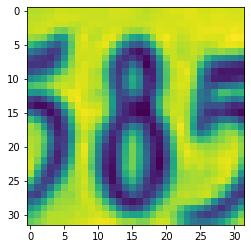

In [28]:
plt.imshow(X_train[21000])
print(f"Label: {y_train[21000]}")

Display 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

As can be seen, the data set sometimes contains multiple numbers. These are the *distractors*. This is something that we will have to keep a lookout for.

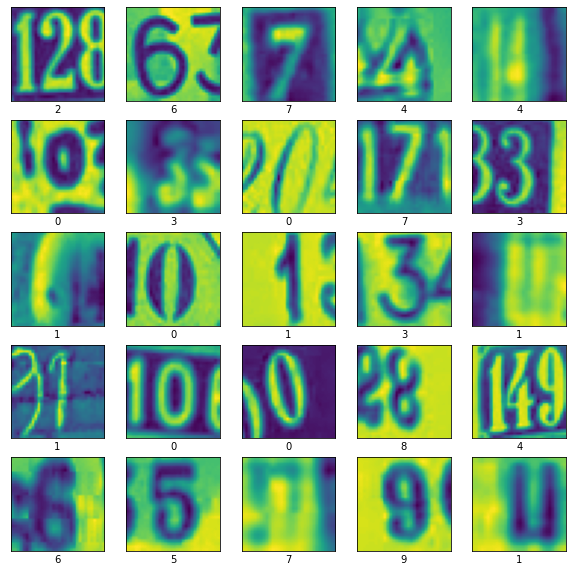

In [29]:
plt.figure(figsize=(10,10))
for i in range(25):
    image = X_train[i]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(y_train[i])
plt.show()

### Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So we normalise each image in the training and test datasets.

In [28]:
# Convert train and test images into 'float64' type
X_train = X_train.astype('float64')
X_val = X_val.astype('float64')
X_test = X_test.astype('float64')

# Normalize the images data
print('Before Normalization Train - Min: {}, Max: {}'.format(X_train.min(), X_train.max()))
print('Before Normalization Validation - Min: {}, Max: {}'.format(X_val.min(), X_val.max()))
print('Before Normalization Test - Min: {}, Max: {}'.format(X_test.min(), X_test.max()))

X_train /= 255.
X_val /= 255.
X_test /= 255.

print('After Normalization Train - Min: {}, Max: {}'.format(X_train.min(), X_train.max()))
print('After Normalization Validation - Min: {}, Max: {}'.format(X_val.min(), X_val.max()))
print('After Normalization Test - Min: {}, Max: {}'.format(X_test.min(), X_test.max()))

Before Normalization Train - Min: 0.0, Max: 254.97450256347656
Before Normalization Validation - Min: 0.0, Max: 254.97450256347656
Before Normalization Test - Min: 0.0, Max: 254.97450256347656
After Normalization Train - Min: 0.0, Max: 0.9999000100528492
After Normalization Validation - Min: 0.0, Max: 0.9999000100528492
After Normalization Test - Min: 0.0, Max: 0.9999000100528492


Do one-hot encoding on the labels (y values)

In [29]:
# converting y data into categorical (one-hot encoding)
print(y_train.shape, y_test.shape, y_val.shape)
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape, y_test.shape, y_val.shape)

(42000,) (18000,) (60000,)
(42000, 10) (18000, 10) (60000, 10)


In [30]:
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(42000, 32, 32) (18000, 32, 32) (60000, 32, 32) (42000, 10) (18000, 10) (60000, 10)


### Define helper functions

Let us define a few helper functiosn that we can use to run and evaluate out models. 

**reduce_learning_rate_on_plateaue** - function to reduce learning rate by monitoring the loss when the model learning plateaues over a few EPOCHs

In [31]:
def reduce_learning_rate_on_plateaue(patience=3,monitor='loss',mode='min'):
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, 
                                                     factor=0.3, 
                                                     patience=patience,
                                                     mode=mode, verbose=1)
    return reduce_lr

**get_early_stopping** - function to stop the model execution when the accuracy does not change over a few EPOCHs

In [32]:
def get_early_stopping(patience=3,monitor='accuracy',mode='max'):
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last X epochs.
    """
    early_stp = tf.keras.callbacks.EarlyStopping(monitor=monitor,
                                                 patience=patience,
                                                 verbose=1, mode=mode)

    return early_stp

**model_eval** - function to evaluate the model

In [33]:
def model_eval(model, X_test, y_val):
  results = model.evaluate(X_test, y_val)
  return results

**plot_acc_val** - function to plot the training accuracy vs test accuracy and training loss vs the test loss

In [34]:
def plot_acc_val(acc, val_acc, loss, val_loss):
  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

**Let us Instantiate the callbacks**

In [35]:
###Instantiate callbacks
early_stopping = get_early_stopping(patience=5, monitor='accuracy')
reduce_lr = reduce_learning_rate_on_plateaue(monitor='loss', mode='max', patience=2)

**Setting model parameraters**

In [36]:
BATCH_SIZE = 200 # Number of training examples to process before updating our models variables
EPOCH = 50 # Number of total EPOCHs to run per model

## Start building the models

Building the neural network requires configuring the layers of the model, then compiling the model.

For this, we will do the following:

1.   A simple Sigmoid model
2.   A simple Relu model
3.   A Relu model with He_normal initializer
4.   A complex deep learning Relu with Batch Normalisation, Dropout and RMSprop optimiser.
5.   A complex deep learning Relu with Batch Normalisation, Dropout and SGD optimiser
6.   A complex deep learning Relu with Batch Normalisation, Dropout and Adam optimiser
7.   A complex deep learning Relu with Batch Normalisation and Adam optimiser

### 1.   A simple Sigmoid model

a. Define the model

In [37]:
def simpleSequential():
  model = Sequential()
  model.add(Flatten(input_shape = X_train.shape[1:]))
  model.add(Activation('sigmoid'))
  model.add(Dense(1024))
  model.add(Activation('sigmoid'))
  model.add(Dense(1024))
  model.add(Activation('sigmoid'))
  model.add(Dense(1024))
  model.add(Activation('sigmoid'))
  model.add(Dense(10))
  model.add(Activation('softmax'))

  sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return model

In [38]:
simpleSeqModel = simpleSequential()

b. Look at the summary

In [39]:
simpleSeqModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1

c. Fit the model

In [40]:
tf.keras.backend.clear_session()
history = simpleSeqModel.fit(X_train, y_train, validation_data= (X_val, y_val), batch_size = BATCH_SIZE, epochs = EPOCH, verbose = 1, callbacks=[reduce_lr, early_stopping])

Epoch 1/50
210/210 [==============================] - 2s 8ms/step - loss: 2.3121 - accuracy: 0.1015 - val_loss: 2.3073 - val_accuracy: 0.1000
Epoch 2/50
210/210 [==============================] - 1s 6ms/step - loss: 2.3060 - accuracy: 0.1009 - val_loss: 2.3084 - val_accuracy: 0.1000
Epoch 3/50
206/210 [============================>.] - ETA: 0s - loss: 2.3067 - accuracy: 0.0984
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
210/210 [==============================] - 1s 6ms/step - loss: 2.3066 - accuracy: 0.0984 - val_loss: 2.3075 - val_accuracy: 0.1000
Epoch 4/50
210/210 [==============================] - 1s 6ms/step - loss: 2.3042 - accuracy: 0.0993 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 5/50
209/210 [============================>.] - ETA: 0s - loss: 2.3039 - accuracy: 0.0981
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
210/210 [==============================] - 1s 6ms/step - loss: 2.3039 - accuracy: 0.0981 - 

d. Evaluate the model using the test data

In [41]:
eval = model_eval(simpleSeqModel, X_test, y_test)

563/563 [==============================] - 1s 2ms/step - loss: 2.3027 - accuracy: 0.0983


e. Plot the accuracy and loss values

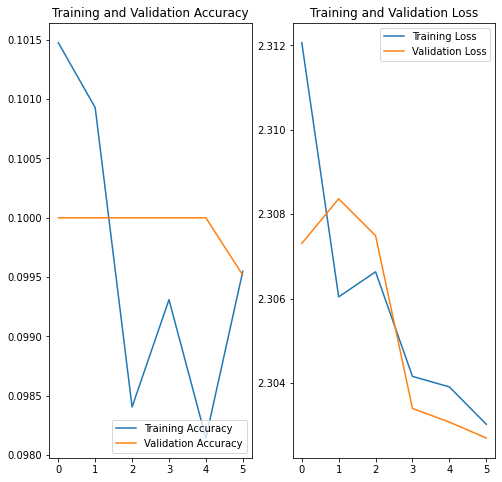

In [42]:
plot_acc_val(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [43]:
resultsDf = pd.DataFrame({'Method':['Simple Sigmoid model'], 
                          'Accuracy (Train)': [history.history['accuracy'][-1]], 
                          'Accuracy (Validation)': [history.history['val_accuracy'][-1]],
                          'Accuracy (Evaluate)': eval[1],
                          'Loss (Train)': [history.history['loss'][-1]],
                          'Loss (Validation)': [history.history['val_loss'][-1]],
                          'Loss (Evaluate)': eval[0]})

In [44]:
resultsDf

,Method,Accuracy (Train),Accuracy (Validation),Accuracy (Evaluate),Loss (Train),Loss (Validation),Loss (Evaluate)
0,Simple Sigmoid model,0.099548,0.099517,0.098333,2.303024,2.302698,2.302742


### 2.   A simple Relu model

a. Define the model

In [45]:
def simpleReluModel():
    model = Sequential()
    model.add(Flatten(input_shape = X_train.shape[1:]))
    model.add(Activation('relu'))    
    model.add(Dense(1024))
    model.add(Activation('relu'))    
    model.add(Dense(1024))
    model.add(Activation('relu'))    
    model.add(Dense(1024))
    model.add(Activation('relu'))    
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [46]:
relu_simple = simpleReluModel()

b. Look at the summary

In [47]:
relu_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1

c. Fit the model

In [48]:
tf.keras.backend.clear_session()
history = relu_simple.fit(X_train, y_train, validation_data= (X_val, y_val), epochs=EPOCH, batch_size = BATCH_SIZE,verbose=1, callbacks=[reduce_lr, early_stopping])

Epoch 1/50
210/210 [==============================] - 2s 7ms/step - loss: 2.2953 - accuracy: 0.1345 - val_loss: 2.2817 - val_accuracy: 0.1860
Epoch 2/50
210/210 [==============================] - 1s 6ms/step - loss: 2.2747 - accuracy: 0.1930 - val_loss: 2.2652 - val_accuracy: 0.2336
Epoch 3/50
205/210 [============================>.] - ETA: 0s - loss: 2.2570 - accuracy: 0.2411
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
210/210 [==============================] - 1s 6ms/step - loss: 2.2568 - accuracy: 0.2415 - val_loss: 2.2448 - val_accuracy: 0.2831
Epoch 4/50
210/210 [==============================] - 1s 6ms/step - loss: 2.2400 - accuracy: 0.3014 - val_loss: 2.2358 - val_accuracy: 0.3128
Epoch 5/50
207/210 [============================>.] - ETA: 0s - loss: 2.2319 - accuracy: 0.3205
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
210/210 [==============================] - 1s 6ms/step - loss: 2.2319 - accuracy: 0.3207 - 

d. Evaluate the model using the test data

In [49]:
eval = model_eval(relu_simple, X_test, y_test)

563/563 [==============================] - 1s 2ms/step - loss: 2.2200 - accuracy: 0.3486


e. Plot the accuracy and loss values

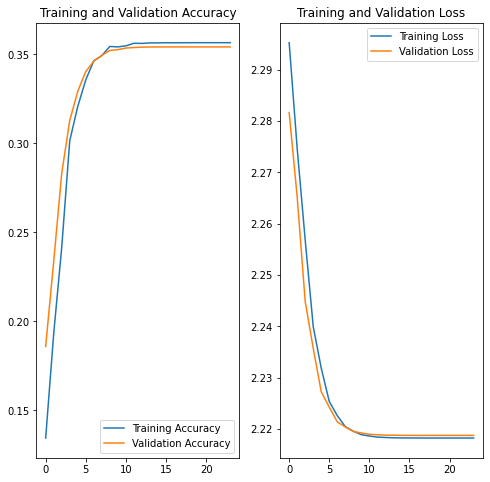

In [50]:
plot_acc_val(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [51]:
tempResultsDf = pd.DataFrame({'Method':['Simple Relu model'], 
                          'Accuracy (Train)': [history.history['accuracy'][-1]], 
                          'Accuracy (Validation)': [history.history['val_accuracy'][-1]],
                          'Accuracy (Evaluate)': eval[1],
                          'Loss (Train)': [history.history['loss'][-1]],
                          'Loss (Validation)': [history.history['val_loss'][-1]],
                          'Loss (Evaluate)': eval[0]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

,Method,Accuracy (Train),Accuracy (Validation),Accuracy (Evaluate),Loss (Train),Loss (Validation),Loss (Evaluate)
0,Simple Sigmoid model,0.099548,0.099517,0.098333,2.303024,2.302698,2.302742
0,Simple Relu model,0.356500,0.354117,0.348556,2.218248,2.218758,2.219951


### 3.   A Relu model with He_normal initializer

a. Define the model

In [52]:
def reluHeModel():
    model = Sequential()
    model.add(Flatten(input_shape = X_train.shape[1:]))
    model.add(Activation('relu'))    
    model.add(Dense(1024, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(1024, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(1024, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('relu'))    
    model.add(Dense(10, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('softmax'))
    
    sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [53]:
relu_he_model = reluHeModel()

b. Look at the summary

In [54]:
relu_he_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1

c. Fit the model

In [55]:
tf.keras.backend.clear_session()
history = relu_he_model.fit(X_train, y_train, validation_data= (X_val, y_val), epochs=EPOCH, batch_size = BATCH_SIZE, verbose=1, callbacks=[reduce_lr, early_stopping])

Epoch 1/50
210/210 [==============================] - 2s 7ms/step - loss: 2.2767 - accuracy: 0.1581 - val_loss: 2.2307 - val_accuracy: 0.2142
Epoch 2/50
210/210 [==============================] - 1s 6ms/step - loss: 2.2007 - accuracy: 0.2575 - val_loss: 2.1598 - val_accuracy: 0.2884
Epoch 3/50
202/210 [===========================>..] - ETA: 0s - loss: 2.1166 - accuracy: 0.3474
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
210/210 [==============================] - 1s 6ms/step - loss: 2.1145 - accuracy: 0.3488 - val_loss: 2.0616 - val_accuracy: 0.3729
Epoch 4/50
210/210 [==============================] - 1s 6ms/step - loss: 2.0310 - accuracy: 0.4275 - val_loss: 2.0084 - val_accuracy: 0.4407
Epoch 5/50
205/210 [============================>.] - ETA: 0s - loss: 1.9886 - accuracy: 0.4486
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
210/210 [==============================] - 1s 6ms/step - loss: 1.9882 - accuracy: 0.4486 - 

d. Evaluate the model using the test data

In [56]:
eval = model_eval(relu_he_model, X_test, y_test)

563/563 [==============================] - 1s 2ms/step - loss: 1.9223 - accuracy: 0.4875


e. plot the accuracy and loss values

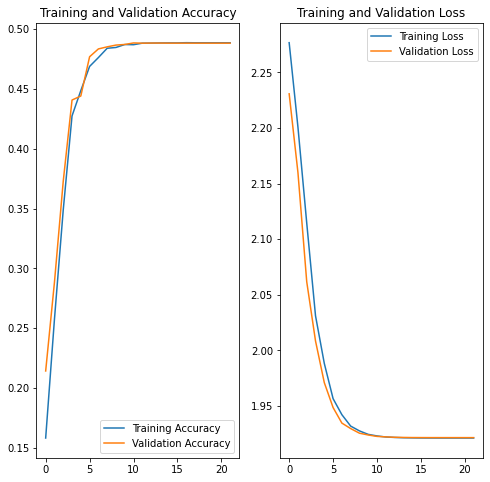

In [57]:
plot_acc_val(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [58]:
tempResultsDf = pd.DataFrame({'Method':['Relu model with He_normal initializer'], 
                          'Accuracy (Train)': [history.history['accuracy'][-1]], 
                          'Accuracy (Validation)': [history.history['val_accuracy'][-1]],
                          'Accuracy (Evaluate)': eval[1],
                          'Loss (Train)': [history.history['loss'][-1]],
                          'Loss (Validation)': [history.history['val_loss'][-1]],
                          'Loss (Evaluate)': eval[0]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

,Method,Accuracy (Train),Accuracy (Validation),Accuracy (Evaluate),Loss (Train),Loss (Validation),Loss (Evaluate)
0,Simple Sigmoid model,0.099548,0.099517,0.098333,2.303024,2.302698,2.302742
0,Simple Relu model,0.356500,0.354117,0.348556,2.218248,2.218758,2.219951
0,Relu model with He_normal initializer,0.488595,0.488267,0.487500,1.921090,1.921455,1.922302


### 4.   A complex deep learning Relu with Batch Normalisation, Dropout and RMSprop optimiser.

a. Define the model

In [59]:
def reluBatchRMSModel():
    model = Sequential()
    
    model.add(Flatten(input_shape = X_train.shape[1:]))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))    

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))    
    model.add(Dropout(0.5)) 

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))    
    model.add(Dropout(0.5)) 

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))
    model.add(Dropout(0.5))   

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))
    model.add(Dropout(0.3))  

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))
    model.add(Dropout(0.2))  

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    rms =tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer = rms, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [60]:
bn_RMS_Model = reluBatchRMSModel()

b. Look at the summary

In [61]:
bn_RMS_Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

c. Fit the model

In [62]:
tf.keras.backend.clear_session()
history = bn_RMS_Model.fit(X_train, y_train,  validation_data= (X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH,verbose=1, callbacks=[reduce_lr, early_stopping])

Epoch 1/50
210/210 [==============================] - 3s 12ms/step - loss: 2.3546 - accuracy: 0.1707 - val_loss: 1.9213 - val_accuracy: 0.2979
Epoch 2/50
210/210 [==============================] - 2s 11ms/step - loss: 1.7787 - accuracy: 0.3809 - val_loss: 1.5416 - val_accuracy: 0.5019
Epoch 3/50
204/210 [============================>.] - ETA: 0s - loss: 1.4959 - accuracy: 0.4921
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
210/210 [==============================] - 2s 11ms/step - loss: 1.4950 - accuracy: 0.4926 - val_loss: 1.3876 - val_accuracy: 0.5671
Epoch 4/50
210/210 [==============================] - 2s 11ms/step - loss: 1.2575 - accuracy: 0.5760 - val_loss: 1.0271 - val_accuracy: 0.6605
Epoch 5/50
204/210 [============================>.] - ETA: 0s - loss: 1.1808 - accuracy: 0.6060
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
210/210 [==============================] - 2s 11ms/step - loss: 1.1793 - accuracy: 0.60

d. Evaluate the model using the test data

In [63]:
eval = model_eval(bn_RMS_Model, X_test, y_test)

563/563 [==============================] - 2s 3ms/step - loss: 0.9269 - accuracy: 0.6997


e. Plot the accuracy and loss values

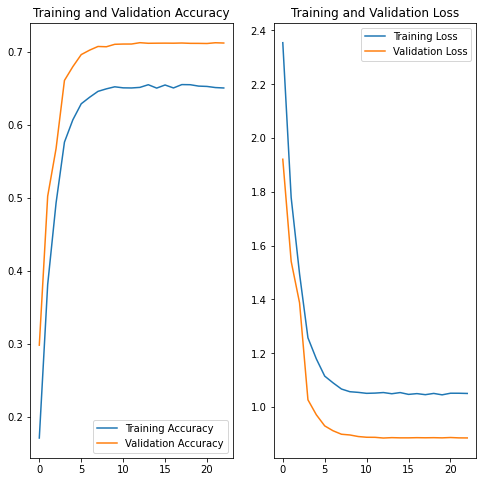

In [64]:
plot_acc_val(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [65]:
tempResultsDf = pd.DataFrame({'Method':['Relu with Batch Normalisation, Dropout and RMSprop optimiser'], 
                          'Accuracy (Train)': [history.history['accuracy'][-1]], 
                          'Accuracy (Validation)': [history.history['val_accuracy'][-1]],
                          'Accuracy (Evaluate)': eval[1],
                          'Loss (Train)': [history.history['loss'][-1]],
                          'Loss (Validation)': [history.history['val_loss'][-1]],
                          'Loss (Evaluate)': eval[0]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

,Method,Accuracy (Train),Accuracy (Validation),Accuracy (Evaluate),Loss (Train),Loss (Validation),Loss (Evaluate)
0,Simple Sigmoid model,0.099548,0.099517,0.098333,2.303024,2.302698,2.302742
0,Simple Relu model,0.356500,0.354117,0.348556,2.218248,2.218758,2.219951
0,Relu model with He_normal initializer,0.488595,0.488267,0.487500,1.921090,1.921455,1.922302
0,"Relu with Batch Normalisation, Dropout and RMS...",0.650119,0.711683,0.699722,1.050697,0.885318,0.926919


### 5.   A complex deep learning Relu with Batch Normalisation, Dropout and SGD optimiser

a. Define the model

In [66]:
def reluBatchSGDModel():
    model = Sequential()
    
    model.add(Flatten(input_shape = X_train.shape[1:]))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))    

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))    
    model.add(Dropout(0.5)) 

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))    
    model.add(Dropout(0.5)) 

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))
    model.add(Dropout(0.5))   

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))
    model.add(Dropout(0.3))  

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))
    model.add(Dropout(0.2))  

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    #adm = tf.keras.optimizers.Adam(learning_rate=0.001)
    sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [67]:
bn_SGD_Model = reluBatchSGDModel()

b. Look at the summary

In [68]:
bn_SGD_Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

c. Fit the model

In [69]:
tf.keras.backend.clear_session()
history = bn_SGD_Model.fit(X_train, y_train,  validation_data= (X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH,verbose=1, callbacks=[reduce_lr, early_stopping])

Epoch 1/50
210/210 [==============================] - 2s 11ms/step - loss: 2.6101 - accuracy: 0.1004 - val_loss: 2.2993 - val_accuracy: 0.1115
Epoch 2/50
210/210 [==============================] - 2s 10ms/step - loss: 2.5208 - accuracy: 0.1056 - val_loss: 2.2754 - val_accuracy: 0.1529
Epoch 3/50
210/210 [==============================] - ETA: 0s - loss: 2.4692 - accuracy: 0.1094
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
210/210 [==============================] - 2s 9ms/step - loss: 2.4692 - accuracy: 0.1094 - val_loss: 2.2608 - val_accuracy: 0.1642
Epoch 4/50
210/210 [==============================] - 2s 9ms/step - loss: 2.4313 - accuracy: 0.1126 - val_loss: 2.2538 - val_accuracy: 0.1737
Epoch 5/50
206/210 [============================>.] - ETA: 0s - loss: 2.4270 - accuracy: 0.1125
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
210/210 [==============================] - 2s 9ms/step - loss: 2.4267 - accuracy: 0.1127 

d. Evaluate the model using the test data

In [70]:
eval = model_eval(bn_SGD_Model, X_test, y_test)

563/563 [==============================] - 2s 3ms/step - loss: 2.2464 - accuracy: 0.1799


e. Plot the accuracy and loss values

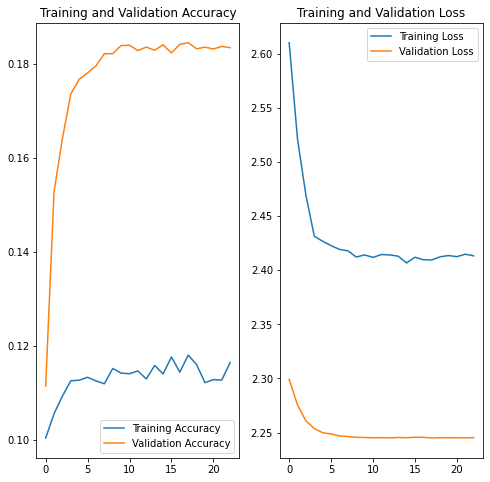

In [71]:
plot_acc_val(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [72]:
tempResultsDf = pd.DataFrame({'Method':['Relu with Batch Normalisation, Dropout and SGD optimiser'], 
                          'Accuracy (Train)': [history.history['accuracy'][-1]], 
                          'Accuracy (Validation)': [history.history['val_accuracy'][-1]],
                          'Accuracy (Evaluate)': eval[1],
                          'Loss (Train)': [history.history['loss'][-1]],
                          'Loss (Validation)': [history.history['val_loss'][-1]],
                          'Loss (Evaluate)': eval[0]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

,Method,Accuracy (Train),Accuracy (Validation),Accuracy (Evaluate),Loss (Train),Loss (Validation),Loss (Evaluate)
0,Simple Sigmoid model,0.099548,0.099517,0.098333,2.303024,2.302698,2.302742
0,Simple Relu model,0.356500,0.354117,0.348556,2.218248,2.218758,2.219951
0,Relu model with He_normal initializer,0.488595,0.488267,0.487500,1.921090,1.921455,1.922302
0,"Relu with Batch Normalisation, Dropout and RMS...",0.650119,0.711683,0.699722,1.050697,0.885318,0.926919
0,"Relu with Batch Normalisation, Dropout and SGD...",0.116500,0.183500,0.179944,2.413242,2.245377,2.246445


### 6.   A complex deep learning Relu with Batch Normalisation, Dropout and Adam optimiser

a. Define the model

In [73]:
def reluBatchAdamModel():
    model = Sequential()
    
    model.add(Flatten(input_shape = X_train.shape[1:]))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))    

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))    
    model.add(Dropout(0.5)) 

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))    
    model.add(Dropout(0.5)) 

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))
    model.add(Dropout(0.5))   

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))
    model.add(Dropout(0.3))  

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))
    model.add(Dropout(0.2))  

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    adm = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer = adm, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [74]:
bn_Adam_Model = reluBatchAdamModel()

b. Look at the summary

In [75]:
bn_Adam_Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

c. Fit the model

In [76]:
tf.keras.backend.clear_session()
history = bn_Adam_Model.fit(X_train, y_train,  validation_data= (X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH,verbose=1, callbacks=[reduce_lr, early_stopping])

Epoch 1/50
210/210 [==============================] - 2s 11ms/step - loss: 2.4337 - accuracy: 0.1186 - val_loss: 2.1716 - val_accuracy: 0.1764
Epoch 2/50
210/210 [==============================] - 2s 9ms/step - loss: 2.0206 - accuracy: 0.2654 - val_loss: 1.6696 - val_accuracy: 0.4129
Epoch 3/50
209/210 [============================>.] - ETA: 0s - loss: 1.6488 - accuracy: 0.4216
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
210/210 [==============================] - 2s 9ms/step - loss: 1.6491 - accuracy: 0.4215 - val_loss: 1.3289 - val_accuracy: 0.5515
Epoch 4/50
210/210 [==============================] - 2s 10ms/step - loss: 1.3679 - accuracy: 0.5330 - val_loss: 1.0897 - val_accuracy: 0.6446
Epoch 5/50
206/210 [============================>.] - ETA: 0s - loss: 1.2629 - accuracy: 0.5758
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
210/210 [==============================] - 2s 9ms/step - loss: 1.2632 - accuracy: 0.5759 

d. Evaluate the model using the test data

In [77]:
eval = model_eval(bn_Adam_Model, X_test, y_test)

563/563 [==============================] - 2s 3ms/step - loss: 0.9147 - accuracy: 0.7067


e. Plot the accuracy and loss values

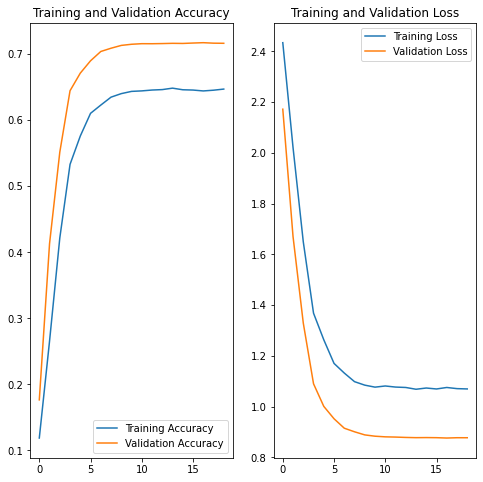

In [78]:
plot_acc_val(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [79]:
tempResultsDf = pd.DataFrame({'Method':['Relu with Batch Normalisation, Dropout and Adam optimiser'], 
                          'Accuracy (Train)': [history.history['accuracy'][-1]], 
                          'Accuracy (Validation)': [history.history['val_accuracy'][-1]],
                          'Accuracy (Evaluate)': eval[1],
                          'Loss (Train)': [history.history['loss'][-1]],
                          'Loss (Validation)': [history.history['val_loss'][-1]],
                          'Loss (Evaluate)': eval[0]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

,Method,Accuracy (Train),Accuracy (Validation),Accuracy (Evaluate),Loss (Train),Loss (Validation),Loss (Evaluate)
0,Simple Sigmoid model,0.099548,0.099517,0.098333,2.303024,2.302698,2.302742
0,Simple Relu model,0.356500,0.354117,0.348556,2.218248,2.218758,2.219951
0,Relu model with He_normal initializer,0.488595,0.488267,0.487500,1.921090,1.921455,1.922302
0,"Relu with Batch Normalisation, Dropout and RMS...",0.650119,0.711683,0.699722,1.050697,0.885318,0.926919
0,"Relu with Batch Normalisation, Dropout and SGD...",0.116500,0.183500,0.179944,2.413242,2.245377,2.246445
0,"Relu with Batch Normalisation, Dropout and Ada...",0.647048,0.716383,0.706722,1.069425,0.877153,0.914741


### 7.   A complex deep learning Relu with Batch Normalisation and Adam optimiser

a. Define the model

In [80]:
def reluBatchAdamNoDropModel():
    model = Sequential()
    
    model.add(Flatten(input_shape = X_train.shape[1:]))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))    

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))    
    

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))    
    

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))
     

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))
    

    model.add(Dense(1024))
    model.add(BatchNormalization())                    
    model.add(Activation('relu'))
    

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
   # adm = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [81]:
bn_Adam_NoDrop_Model = reluBatchAdamNoDropModel()

b. Look at the summary

In [82]:
bn_Adam_NoDrop_Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1

c. Fit the model

In [83]:
tf.keras.backend.clear_session()
history = bn_Adam_NoDrop_Model.fit(X_train, y_train,  validation_data= (X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH,verbose=1, callbacks=[reduce_lr, early_stopping])

Epoch 1/50
210/210 [==============================] - 2s 11ms/step - loss: 1.6705 - accuracy: 0.4257 - val_loss: 1.6292 - val_accuracy: 0.4854
Epoch 2/50
210/210 [==============================] - 2s 9ms/step - loss: 1.2573 - accuracy: 0.5773 - val_loss: 1.2303 - val_accuracy: 0.6122
Epoch 3/50
208/210 [============================>.] - ETA: 0s - loss: 1.0756 - accuracy: 0.6392
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
210/210 [==============================] - 2s 9ms/step - loss: 1.0748 - accuracy: 0.6395 - val_loss: 1.0782 - val_accuracy: 0.6435
Epoch 4/50
210/210 [==============================] - 2s 9ms/step - loss: 0.8212 - accuracy: 0.7240 - val_loss: 0.7821 - val_accuracy: 0.7409
Epoch 5/50
207/210 [============================>.] - ETA: 0s - loss: 0.7384 - accuracy: 0.7533
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
210/210 [==============================] - 2s 9ms/step - loss: 0.7374 - accuracy: 0.7537 -

d. Evaluate the model using the test data

In [84]:
eval = model_eval(bn_Adam_NoDrop_Model, X_test, y_test)

563/563 [==============================] - 2s 3ms/step - loss: 0.7282 - accuracy: 0.7803


e. Plot the accuracy and loss values

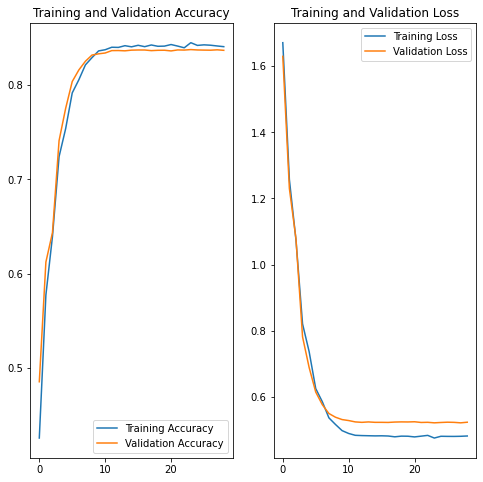

In [85]:
plot_acc_val(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [86]:
tempResultsDf = pd.DataFrame({'Method':['Relu with Batch Normalisation and Adam optimiser'], 
                          'Accuracy (Train)': [history.history['accuracy'][-1]], 
                          'Accuracy (Validation)': [history.history['val_accuracy'][-1]],
                          'Accuracy (Evaluate)': eval[1],
                          'Loss (Train)': [history.history['loss'][-1]],
                          'Loss (Validation)': [history.history['val_loss'][-1]],
                          'Loss (Evaluate)': eval[0]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

,Method,Accuracy (Train),Accuracy (Validation),Accuracy (Evaluate),Loss (Train),Loss (Validation),Loss (Evaluate)
0,Simple Sigmoid model,0.099548,0.099517,0.098333,2.303024,2.302698,2.302742
0,Simple Relu model,0.356500,0.354117,0.348556,2.218248,2.218758,2.219951
0,Relu model with He_normal initializer,0.488595,0.488267,0.487500,1.921090,1.921455,1.922302
0,"Relu with Batch Normalisation, Dropout and RMS...",0.650119,0.711683,0.699722,1.050697,0.885318,0.926919
0,"Relu with Batch Normalisation, Dropout and SGD...",0.116500,0.183500,0.179944,2.413242,2.245377,2.246445
0,"Relu with Batch Normalisation, Dropout and Ada...",0.647048,0.716383,0.706722,1.069425,0.877153,0.914741
0,Relu with Batch Normalisation and Adam optimiser,0.840595,0.836717,0.780278,0.482708,0.524308,0.728182


As can be seen from the model table, the best performance is by the Relu Model with Batch Normalisation and using an Adam optimiser. 

Interstingly, adding Dropouts made the accuracy worse

But the Training Accuracy (84.1%), Validation Accuracy (83.7%) and Test Accuracy (78%) does not seem to be increasing even after trying to tweak the model using many parameters. 

The reason **could** be because of the *distractors* that we mentioned at the begining, the data set sometimes containing multiple numbers.

## Make predictions and explore

With the model trained, we can use it to make predictions

In [87]:
predictions = bn_Adam_NoDrop_Model.predict(X_test)
predictions

array([[1.18287981e-01, 8.77581760e-02, 9.63295922e-02, ...,
        8.29082131e-02, 9.88363400e-02, 1.09463595e-01],
       [1.76075540e-04, 1.17576506e-03, 9.78881791e-02, ...,
        8.00546110e-01, 1.13891147e-03, 3.31572141e-03],
       [1.08705672e-06, 1.26271025e-05, 9.99851108e-01, ...,
        1.54607378e-07, 1.09028893e-04, 1.66610596e-06],
       ...,
       [1.24955261e-06, 2.90566823e-04, 7.70537736e-06, ...,
        9.99696612e-01, 3.19737694e-07, 4.50296881e-07],
       [2.12336238e-03, 1.59803203e-05, 1.13536764e-04, ...,
        1.04425737e-04, 9.35684331e-03, 9.76092577e-01],
       [9.53793451e-02, 8.27993304e-02, 2.54396886e-01, ...,
        1.21058613e-01, 8.33060965e-02, 7.35013932e-02]], dtype=float32)

In [88]:
y_pred = np.argmax(bn_Adam_NoDrop_Model.predict(X_test), axis=1)
print(y_pred)
print(y_pred.shape)

[0 7 2 ... 7 9 2]
(18000,)


In [89]:
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [90]:
count = 0
for i in y_pred:
  if y_pred[i] == y_test1[i]:
    count+=1
  
print('Total count of correct predictions: {}'.format(count))
print('Percentage of correct predictions: {}'.format(count*100/y_pred.size))

Total count of correct predictions: 14316
Percentage of correct predictions: 79.53333333333333


The model has been able to correctly predict almost 80% of the test data. Considering that the images contains multiple numbers, this seems to be a good prediction. 

In [91]:
from sklearn.metrics import classification_report, confusion_matrix

In [92]:
print(confusion_matrix(y_test1, y_pred))

[[1513   43   51   26   35   10   48   13   31   44]
 [  47 1488   50   50   64   10   22   54   21   22]
 [  43   39 1443   38   36   19   14   82   35   54]
 [  39   39   87 1228   27  154   33   41   35   36]
 [  44   55   60   24 1486   19   42   20   24   38]
 [  43   23   48  112   18 1332   80   15   48   49]
 [  88   29   46   20   56   67 1389   14   97   26]
 [  35   74  109   27   20   12   10 1489   11   21]
 [  78   43   72   51   26   58   92   17 1304   71]
 [  96   35   63   40   39   63   18   25   52 1373]]


In [93]:
print(classification_report(y_test1, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      1814
           1       0.80      0.81      0.81      1828
           2       0.71      0.80      0.75      1803
           3       0.76      0.71      0.74      1719
           4       0.82      0.82      0.82      1812
           5       0.76      0.75      0.76      1768
           6       0.79      0.76      0.78      1832
           7       0.84      0.82      0.83      1808
           8       0.79      0.72      0.75      1812
           9       0.79      0.76      0.78      1804

    accuracy                           0.78     18000
   macro avg       0.78      0.78      0.78     18000
weighted avg       0.78      0.78      0.78     18000



The classification report gives a glimpse into the preformance of the model.

The Overall performance and recall of the model is high as is the F1 score.



Actual Label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted Label: [9.95734930e-01 1.29384634e-05 1.37349204e-07 1.89424384e-06
 6.96975007e-07 2.22020958e-06 1.09364555e-04 1.16274384e-06
 5.65864184e-06 4.13094368e-03]


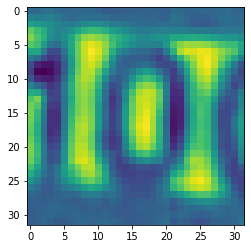

In [94]:
plt.imshow(X_test[15000])
print(f"Actual Label: {y_test[15000]}")
print(f"Predicted Label: {predictions[15000]}")

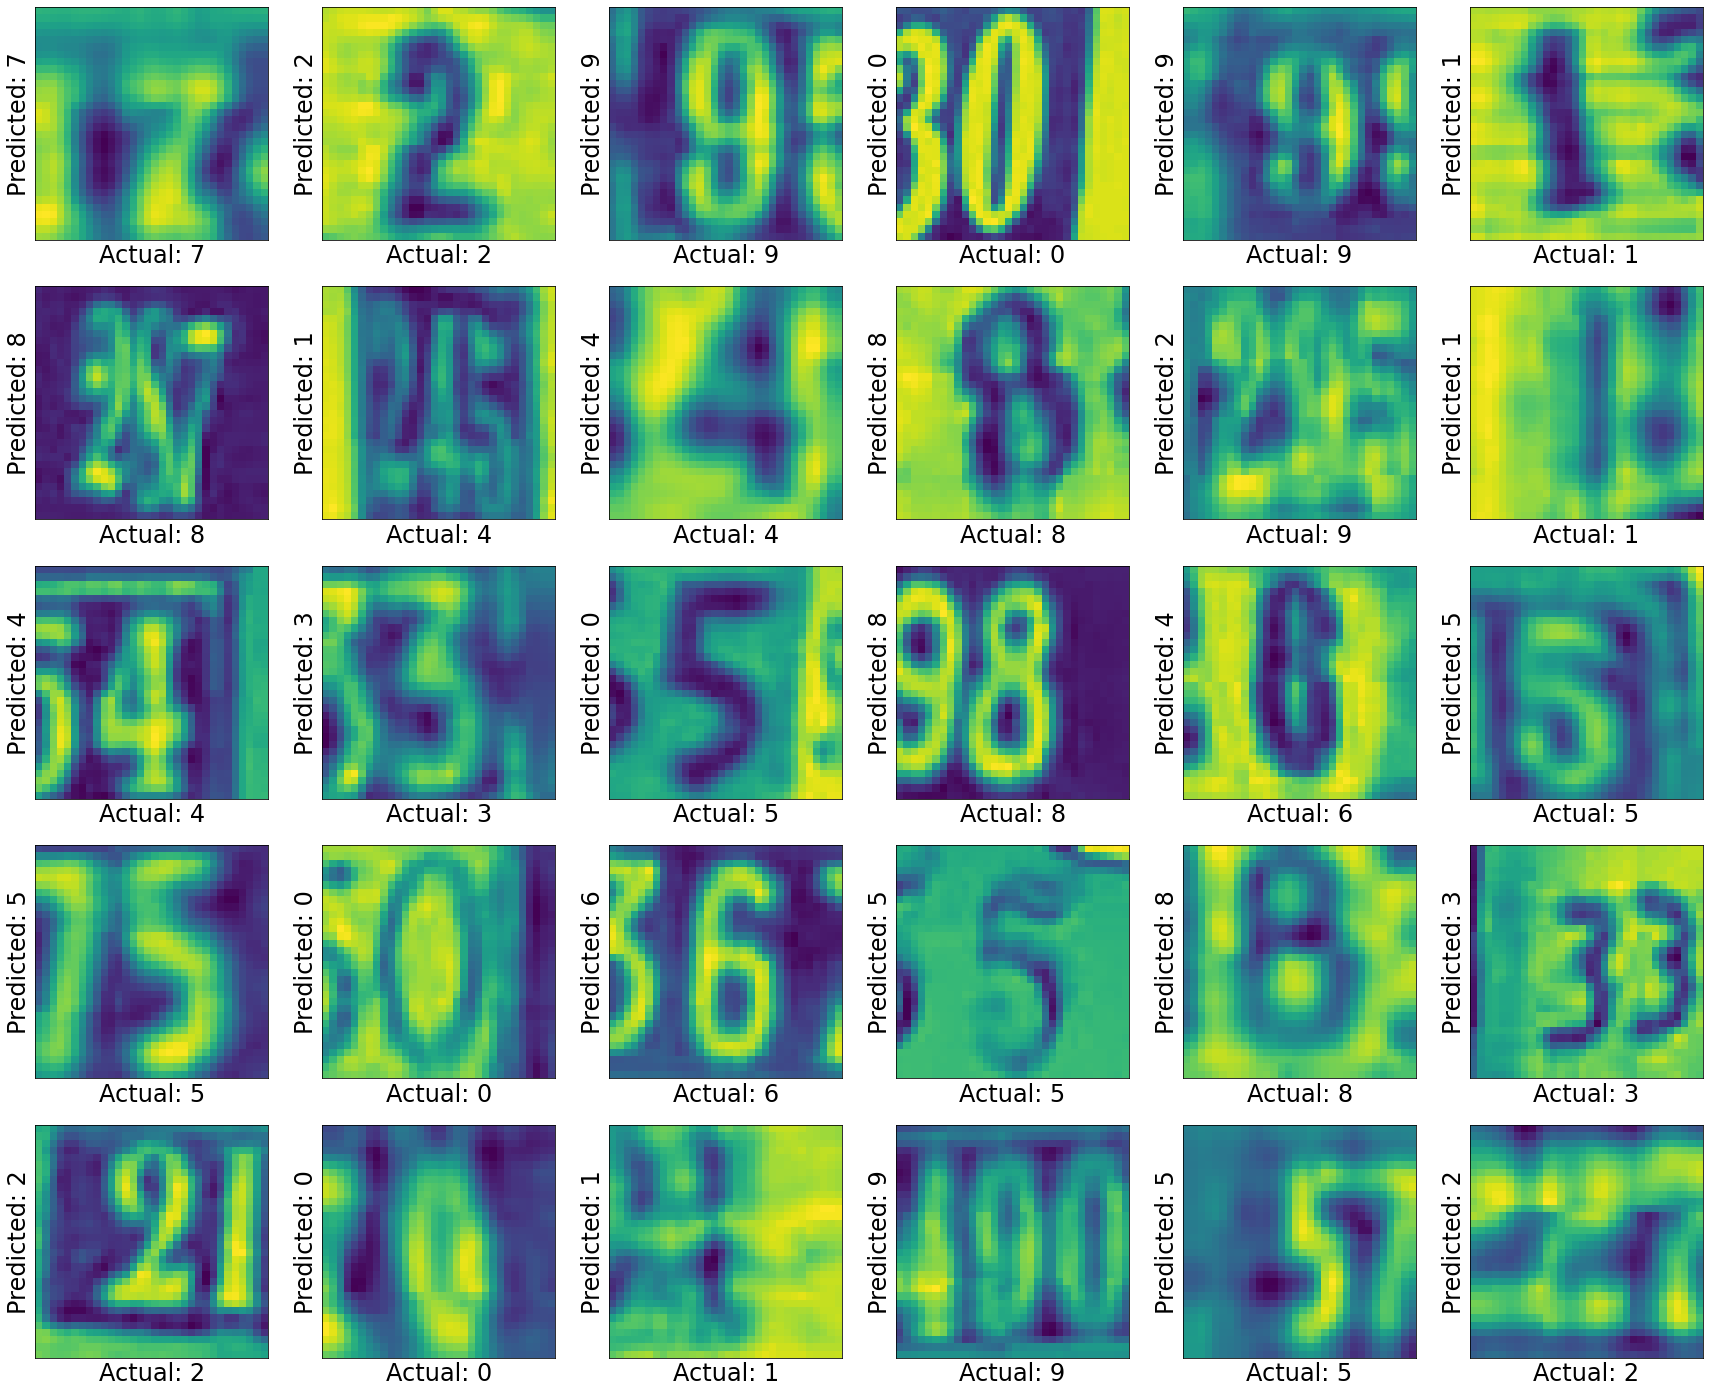

In [95]:
plt.figure(figsize=(30,30))

for i in range(1,31):
    image = X_test[i]
    plt.subplot(6,6,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(f"Actual: {y_test1[i]}", fontsize=24)  
    plt.ylabel(f"Predicted: {y_pred[i]}", fontsize=24)
plt.show()
